# Analyze data downloaded from Google Takeout
https://takeout.google.com

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

In [2]:
def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"
    

def parse_json(json):
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                     json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
    df["accuracy"] = locations.apply(lambda x: x["accuracy"])
    df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = locations.apply(extract_activity)
    return df

In [3]:
%time df = parse_json(pd.read_json("../../../Downloads/locations.json"))
df.shape

CPU times: user 5min 24s, sys: 3.25 s, total: 5min 27s
Wall time: 5min 29s


(1025368, 7)

In [4]:
# http://thematicmapping.org/downloads/world_borders.php
world = gp.read_file('./TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp')

CPU times: user 231 ms, sys: 26.6 ms, total: 258 ms
Wall time: 296 ms


In [5]:
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    

def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()


def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()


def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)

# World

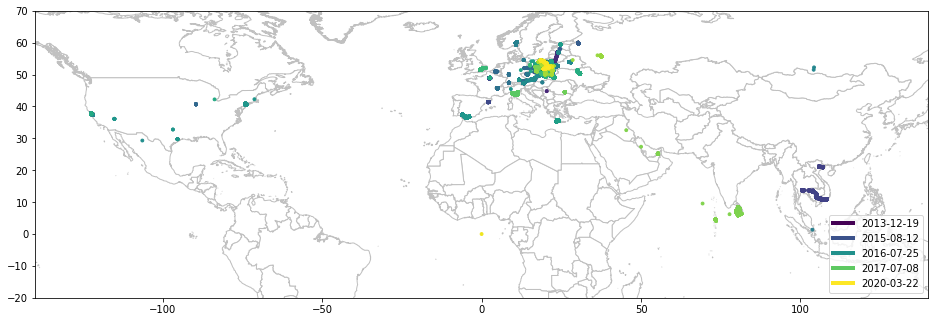

In [6]:
draw_map(df, sg.box(-140, -20, 140, 70))

# Europe

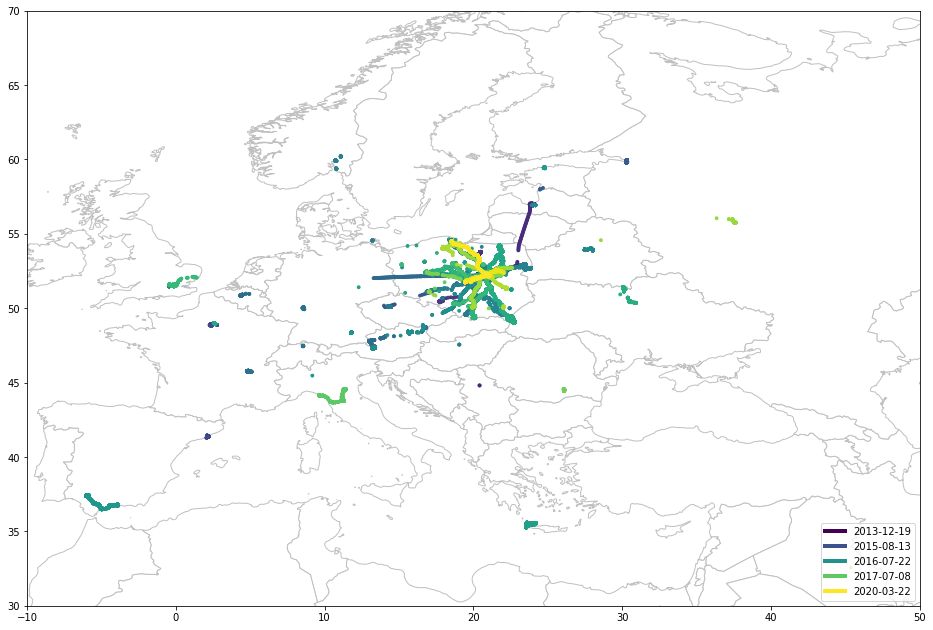

In [7]:
draw_map(df, sg.box(-10, 30, 50, 70))

# JCrete

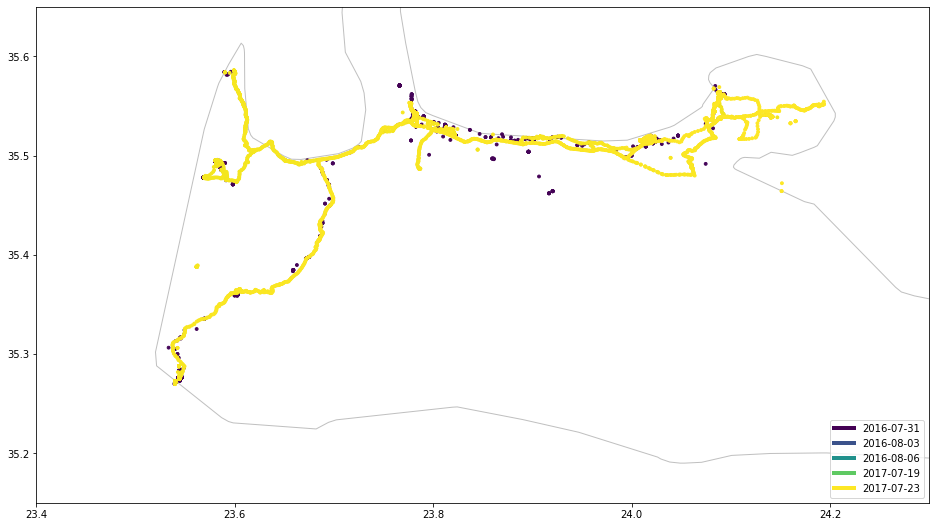

In [8]:
draw_map(df, sg.box(23.4, 35.15, 24.3, 35.65))

# Poland

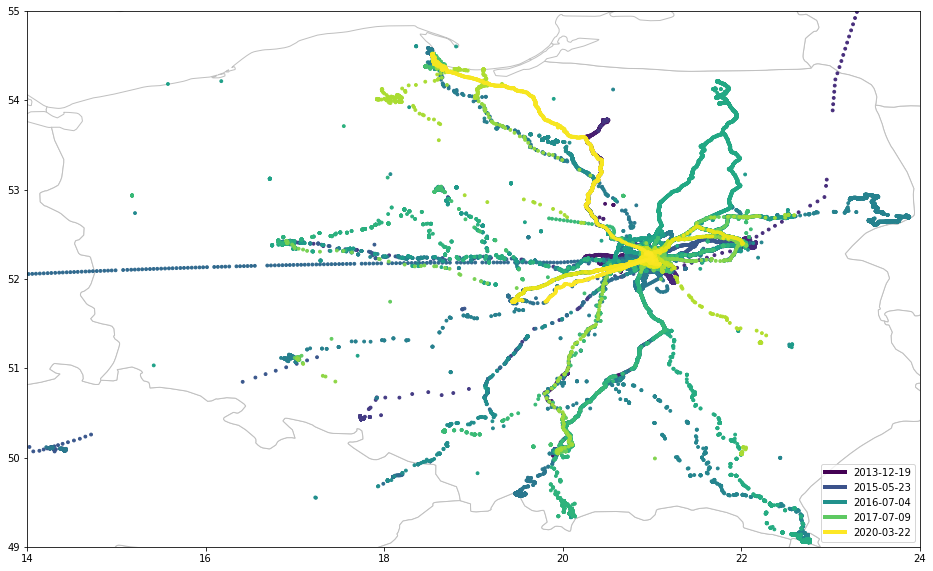

In [9]:
draw_map(df, sg.box(14, 49, 24, 55))

# Warsaw

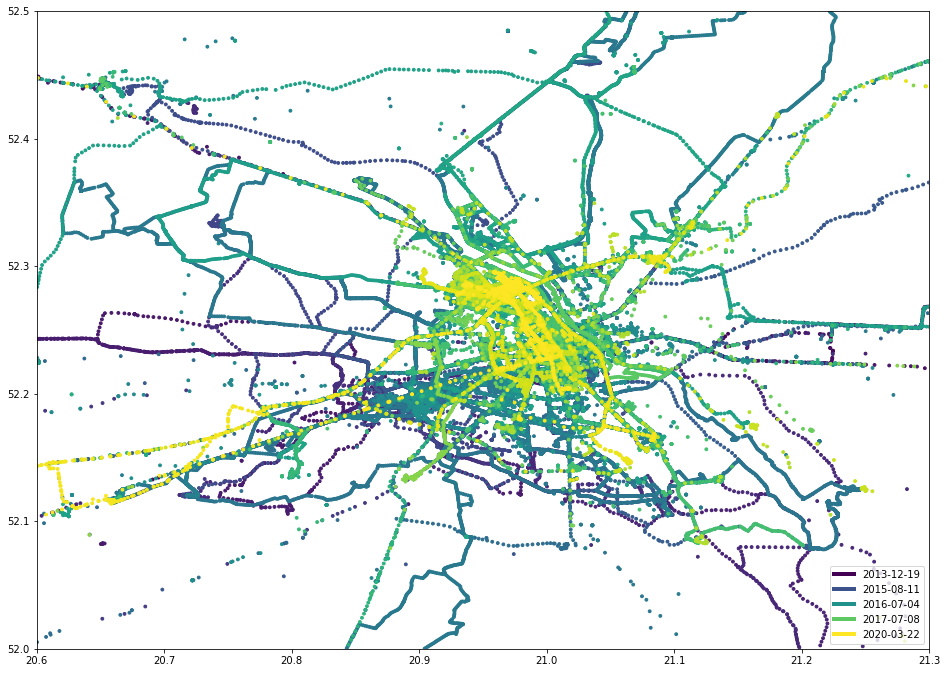

In [10]:
draw_map(df, sg.box(20.6, 52, 21.3, 52.5))

## Zoom in

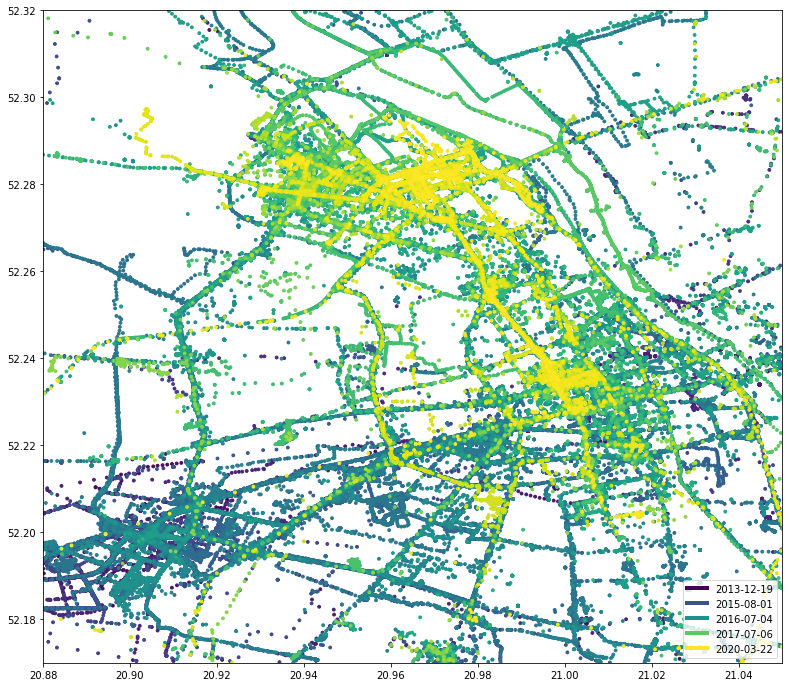

In [11]:
draw_map(df, sg.box(20.88, 52.17, 21.05, 52.32))

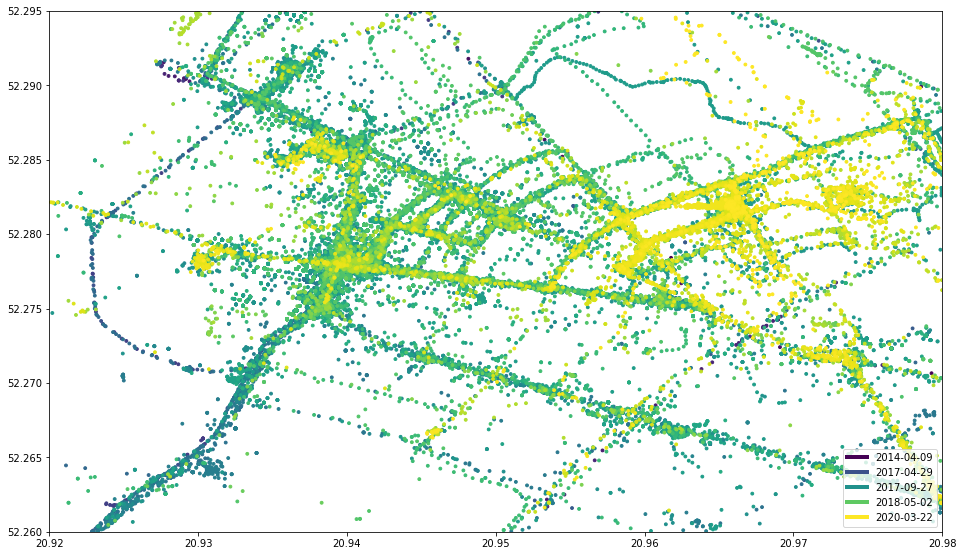

In [12]:
draw_map(df, sg.box(20.92, 52.26, 20.98, 52.295))

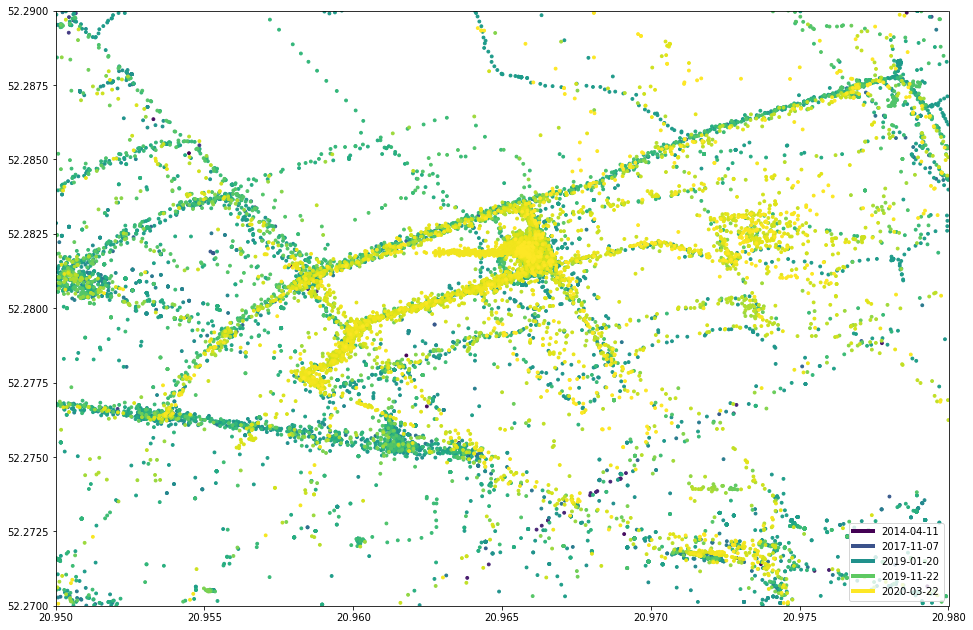

In [13]:
draw_map(df, sg.box(20.95, 52.27, 20.98, 52.29))

## Warsaw in vehicle

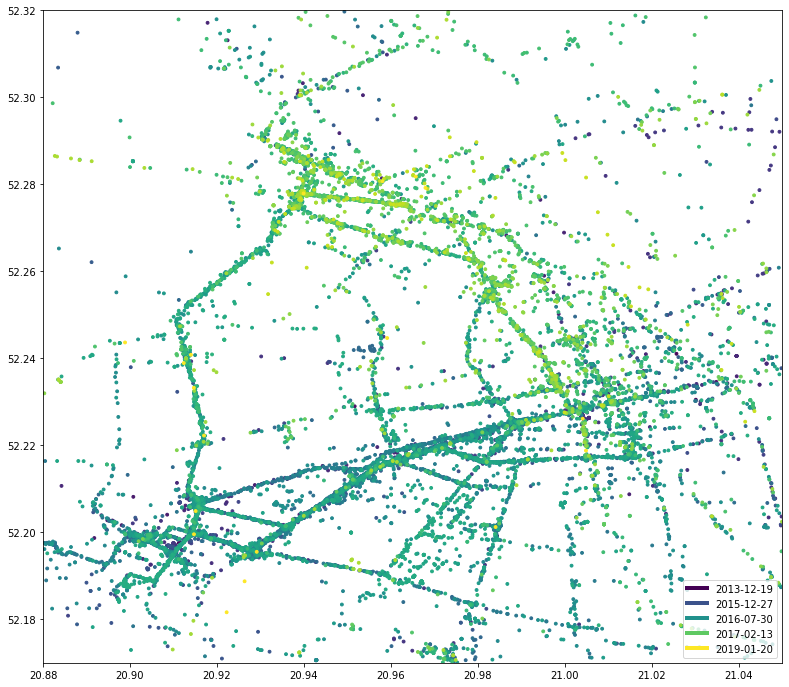

In [14]:
draw_map(df[df.activity == 'IN_VEHICLE'], sg.box(20.88, 52.17, 21.05, 52.32))

## ...and by foot

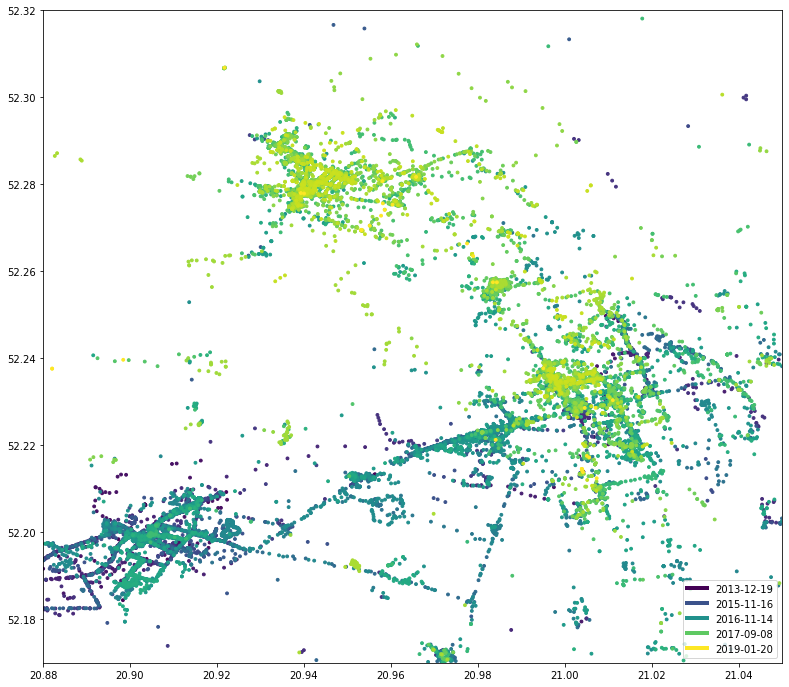

In [15]:
draw_map(df[df.activity == 'ON_FOOT'], sg.box(20.88, 52.17, 21.05, 52.32))

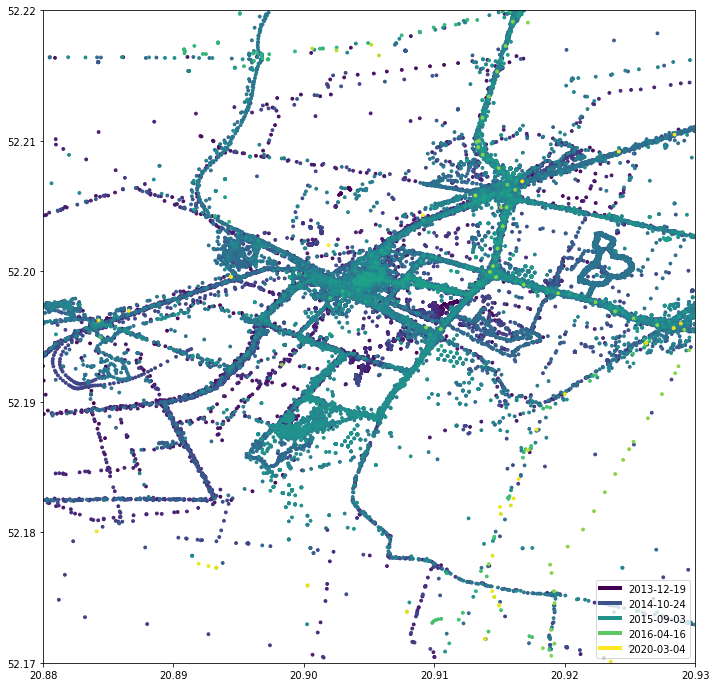

In [16]:
draw_map(df, sg.box(20.88, 52.17, 20.93, 52.22))

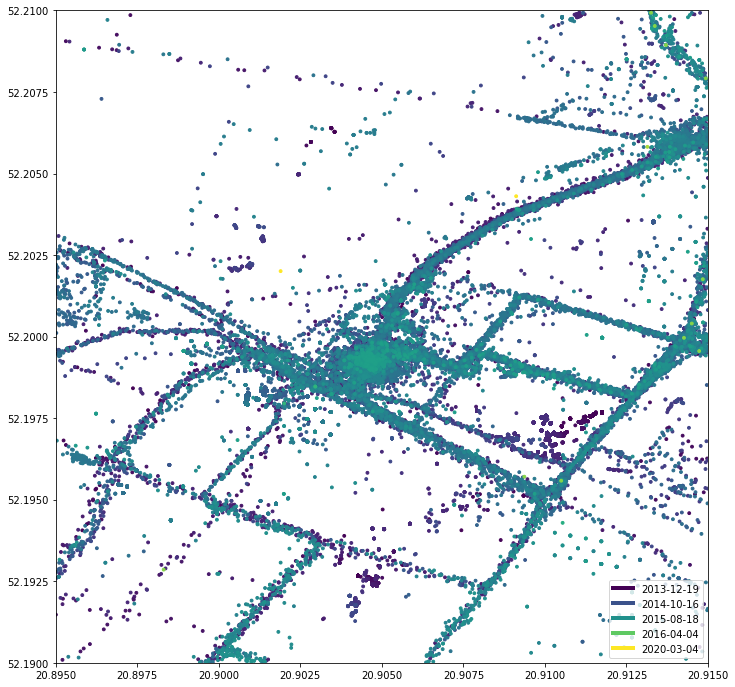

In [17]:
draw_map(df, sg.box(20.895, 52.19, 20.915, 52.21))

# Sri Lanka

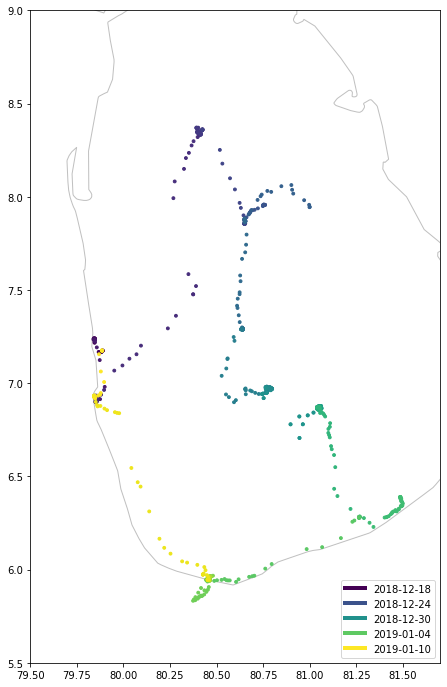

In [18]:
draw_map(df, sg.box(79.5, 5.5, 81.7, 9))

# Thailand

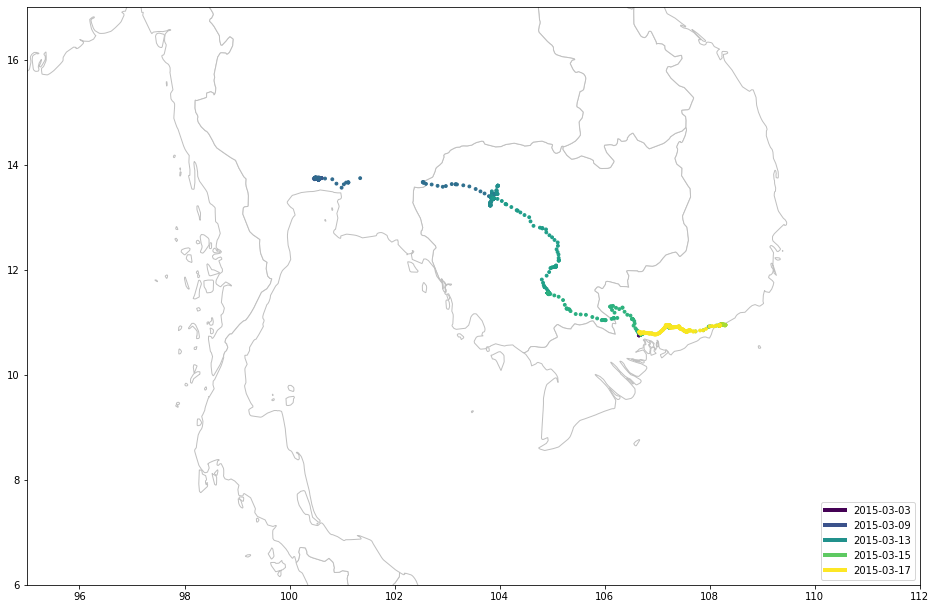

In [19]:
draw_map(df, sg.box(95, 6, 112, 17))

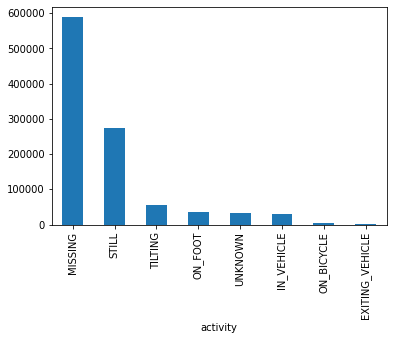

In [20]:
df.groupby(by=df.activity).agg('count').geometry.sort_values(ascending=False).plot.bar()

# Plot activity frequency

In [21]:
def dt_to_date(dt):
    return dt.date()

def dt_to_first_day_of_month(dt):
    return dt_to_date(dt).replace(day=1)

def aggregate_by(df, fun):
        tuples = [(activity, df[df.activity == activity].groupby(df.timestamp.apply(fun)).activity.agg('count')) 
              for activity 
              in df.activity.drop_duplicates()]
        return pd.DataFrame(dict(tuples))

In [22]:
by_month = aggregate_by(df, dt_to_first_day_of_month)

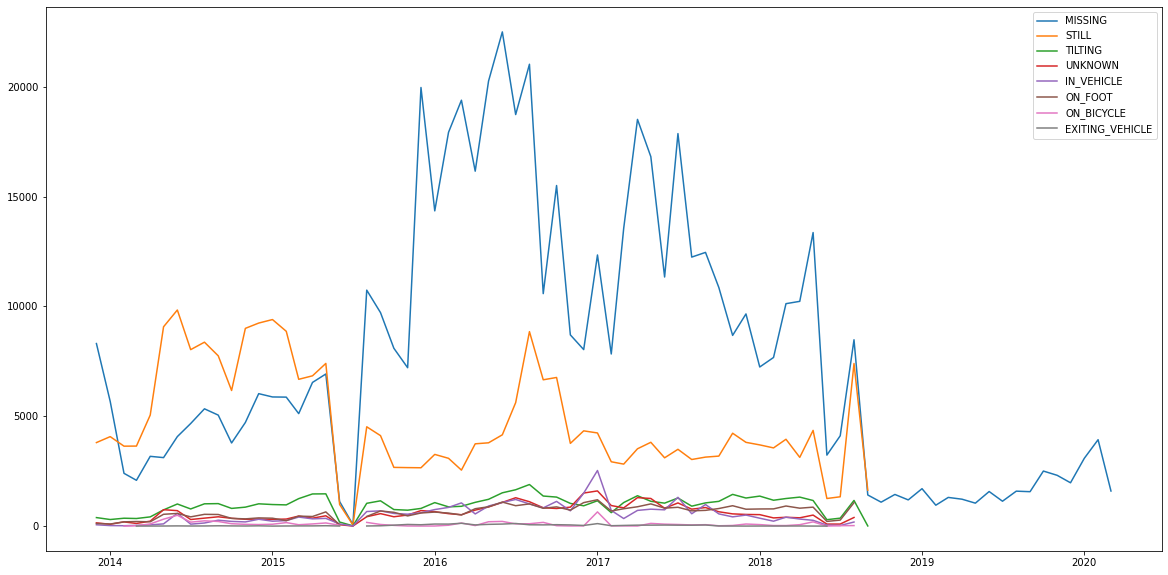

In [23]:
by_month.plot(figsize=[20,10])

In [24]:
by_day = aggregate_by(df, dt_to_date)

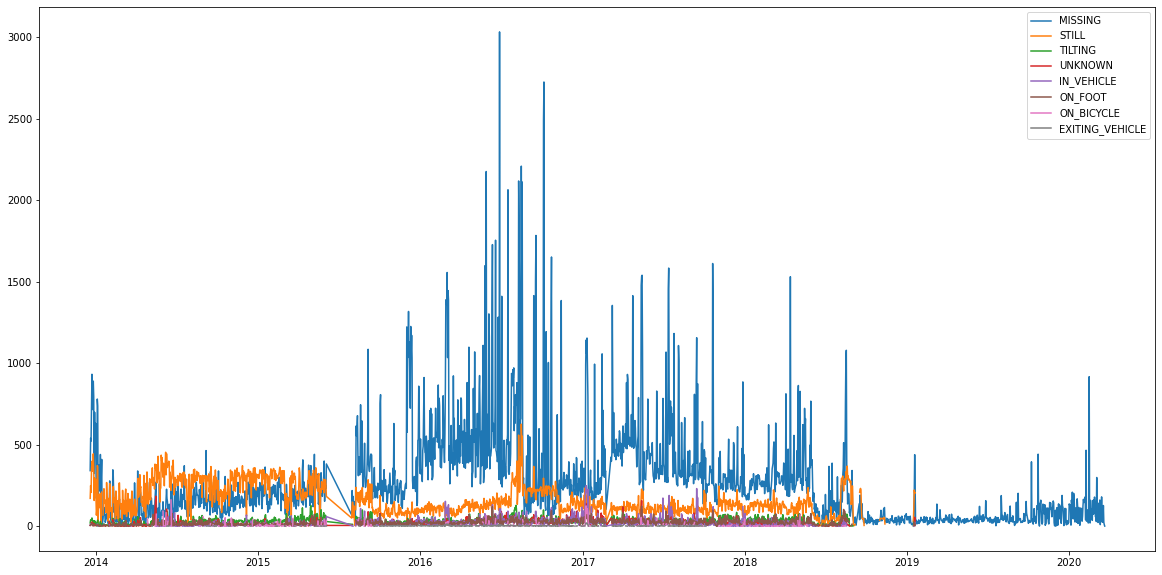

In [25]:
by_day.plot(figsize=[20,10])

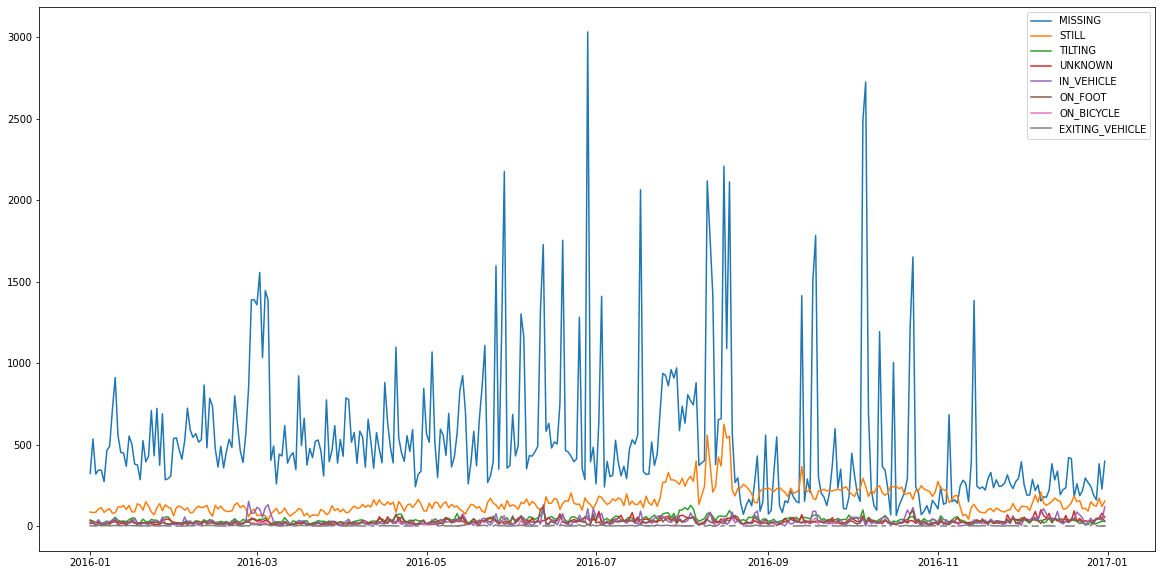

In [26]:
by_day[(by_day.index >= dt.date(2016, 1, 1)) & (by_day.index < dt.date(2017, 1, 1))].plot(figsize=[20,10])

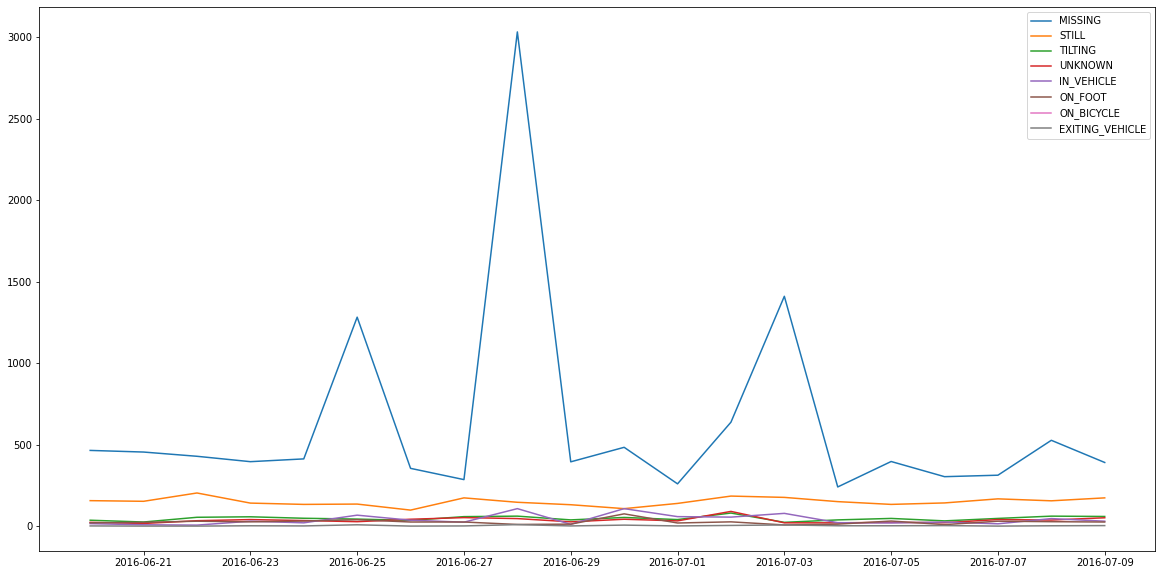

In [27]:
by_day[(by_day.index >= dt.date(2016, 6, 20)) & (by_day.index < dt.date(2016, 7, 10))].plot(figsize=[20,10])

In [28]:
busy_day = df[df.timestamp.apply(dt_to_date) == dt.date(2016, 6, 28)]

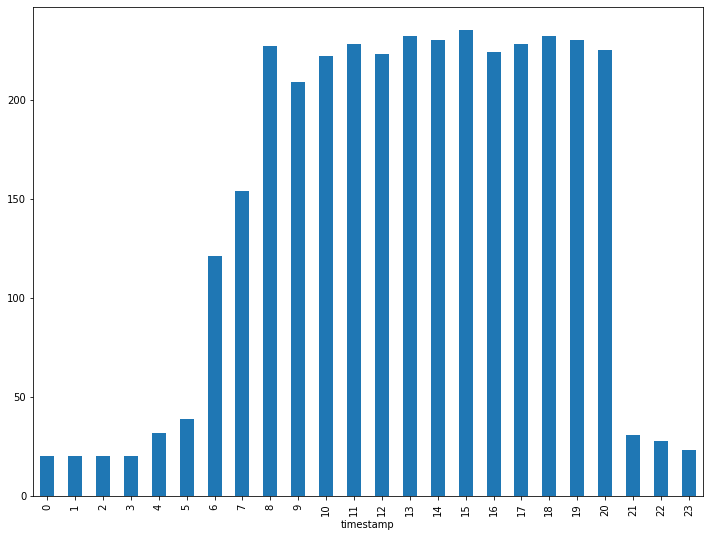

In [29]:
busy_day.groupby(busy_day.timestamp.dt.hour).agg('count').geometry.plot.bar(figsize=[12, 9])

# Altitude histogram

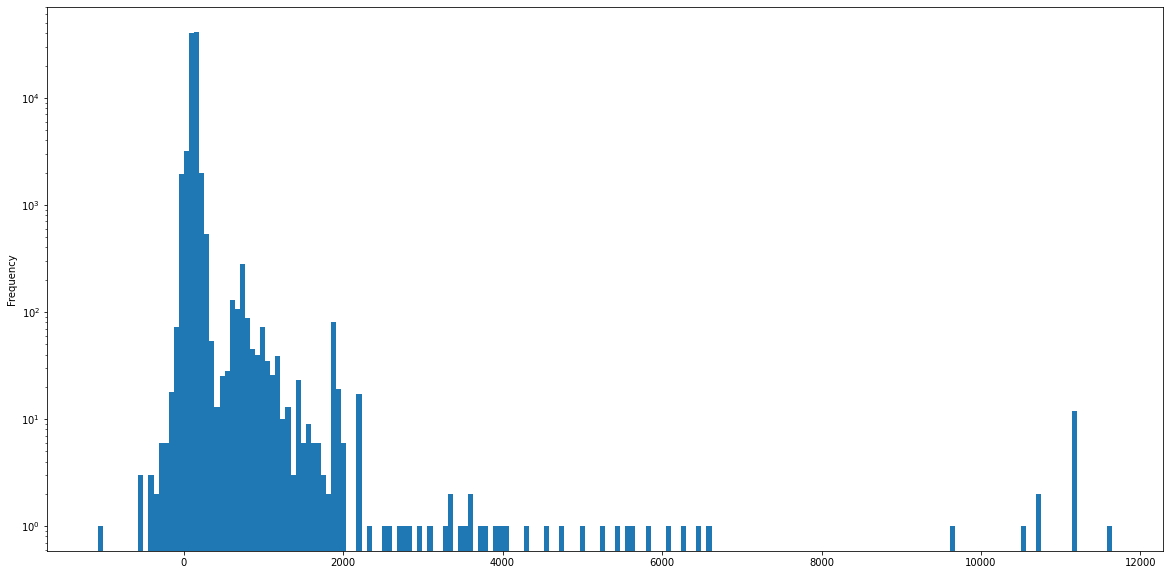

In [34]:
df.altitude.plot.hist(figsize=[20,10], bins=200, log=True)

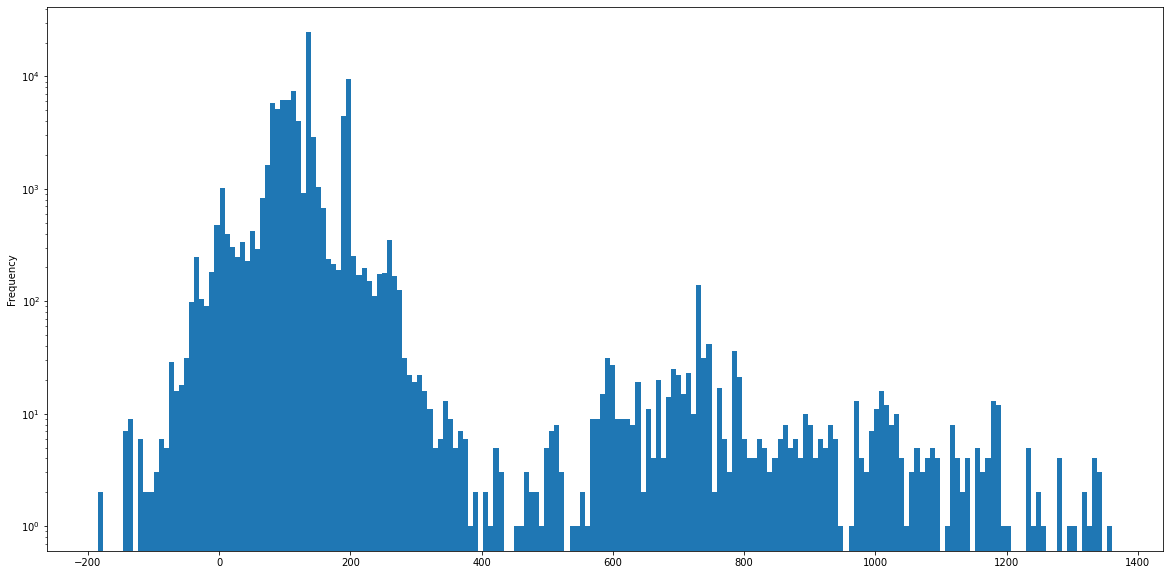

In [31]:
alt = df.altitude
alt[(alt> -200) & (alt < 1400)].plot.hist(figsize=[20,10], bins=200, log=True)

In [32]:
alt.quantile(0.5)

132.0